# Report on Ensemble Empirical Mode Decomposition (EEMD) method

This technique aims at decomposing an input power signal into trend, seasonality and random components. The trend component is then used for computing the degradation factor (or equivalently the degradation rate). The methodology has the three following steps:
- First, we apply EEMD algorithm. This step takes as input a power signal and outputs a set of oscillatory functions (see below for more details).
- Second, we obtain the spectral representation of the oscillatory functions by Fourier transform (FT). According to their power spectrum, the oscillatory functions are grouped into trend, seasonal and random components. 
- Finally, we estimate the degradation factor (or equivalently the degradation rate) from the trend component.

EEMD is a data-driven, adaptive decomposition method which is a generalization of the Empirical Mode Decomposition (EMD) method. EMD is a technique for decomposing an input signal into a set of oscillatory components named Intrinsic Mode Functions (IMFs). The IMFs must satisfy the following two conditions:
1. the number of extrema and the number of zero-crossings must be the same or differ at most by one
2. at any point, the mean value of the envelope defined by the local maxima and the envelope defined by the local minima is zero.

For a description of the EMD algorithm see [[1]](https://srcole.github.io/2016/01/18/emd/) or [[2]](https://www.hindawi.com/journals/jece/2008/293056/). EEMD uses *M* slightly perturbed copies of the input signal, and applies EMD to each of these copies. Thus, obtaining one set of IMFs for each perturbed signal. The output set of IMFs is obtained by averaging over the ensemble of IMFs, in this way the noise cancels out.

The notebook is organized as follows. In the first part, we apply the methodology to one basic dataset. We generalize for all datasets for the basic idelized PV plant at the second part of the notebook.

In the notebook `3.1-mb-decomposition-EEMD.ipynb`, the EEMD is applied for the rest of synthetic time series, namely *soil*, *weather* and *soil+weather*.

**Open Questions**

- What about precision??

**Conclusions/Summary**

- For the basic synthetic catalog, we obtain a **RMSE of 0.362 %/year**. This method does not perform well in estimating a slowly varying degradation rate, and it is better suite for estimating periodical effects.
- The first step of EEMD is to generate a set of perturbed copies of the input signal. These copies are generated by adding noise to the input signal. Since the generation of the noise is random, EEMD is a stochastic process. The results obtained with this method heavily relies on this first step, and I haven't achieved convergence. That is, if I rerun the code for a different noise's seed, the results are different. 

**Resources/Bibliograpy**

- [1] [Empirical Mode Decomposition (EMD)](https://srcole.github.io/2016/01/18/emd/)
- [2] [EMD](https://www.hindawi.com/journals/jece/2008/293056/)
- [3] [Ensemble Empirical Mode Decomposition (EEMD)](https://www.worldscientific.com/doi/abs/10.1142/S1793536909000047)
- [4] [EEMD + LSTM](https://link.springer.com/article/10.1007/s11269-019-02345-1)

**Requirements**

- [PyEMD](https://buildmedia.readthedocs.org/media/pdf/pyemd/latest/pyemd.pdf)

In [23]:
# In the root of the repo run "pip install --editable ."

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Replace sample_func_dir by the name of directory in src/ and replace sample_func_file the
# file name in src/sample_func_dir

from src.data.import_data import import_df_from_zip_pkl, import_df_info_from_zip
from src.data.make_dataset import downsample_dataframe
from src.models.eemd_decomposition import eemd_analysis, eemd_analysis_check_extrema, plot_eemd_rd, plot_eemd_rd_extrema, gradientDescent
from scipy import fftpack
import matplotlib.pyplot as plt
%matplotlib inline
from PyEMD import EMD, EEMD
from scipy import fftpack
from sklearn.metrics import mean_squared_error
import numpy as np
from matplotlib.offsetbox import AnchoredText

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## First part : one synthetic basic dataset

In [17]:
# Load data 
csv_index   = 9
synth_name  = "basic"
path_to_zip = "../data/raw/synthetic_" + synth_name + ".zip"
df_basic    = import_df_from_zip_pkl(path_to_zip, index=csv_index, verbose=True)


importing synthetic_basic/synthetic_basic_010.pkl

time for importing dataframe: 0.66 seconds


In [18]:
df_info      = import_df_info_from_zip(path_to_zip, verbose=True)
r_d_true_0   = df_info.Degradation_rate_linear.iloc[9]
print (r_d_true_0)
df_info.iloc[7:10]

Found the following dataset info-files  ['synthetic_basic/synthetic_basic_info.csv']

importing synthetic_basic/synthetic_basic_info.csv

-0.006028896999999999


,Plant,Degradation_rate_linear,Location
7,synthetic_basic_008,-0.012207,NC
8,synthetic_basic_009,-0.012574,NC
9,synthetic_basic_010,-0.006029,NC


In [19]:
# Preprocess data
df_basic = downsample_dataframe(df_basic, night_method='basic', clip_method='universal')

In [20]:
df_basic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2015-01-01 00:00:00-05:00 to 2019-12-31 00:00:00-05:00
Freq: D
Data columns (total 4 columns):
Power          1826 non-null float64
Degradation    1826 non-null float64
Soiling        1826 non-null int64
Faults         1826 non-null int64
dtypes: float64(2), int64(2)
memory usage: 151.3 KB


In [21]:
df_basic.head()

,Power,Degradation,Soiling,Faults
datetime,,,,
2015-01-01 00:00:00-05:00,371.108434,0.99999,1,1
2015-01-02 00:00:00-05:00,376.153226,0.99997,1,1
2015-01-03 00:00:00-05:00,378.401606,0.99996,1,1
2015-01-04 00:00:00-05:00,380.952000,0.99994,1,1
2015-01-05 00:00:00-05:00,383.800797,0.99992,1,1


Text(0.5, 0, 'time [days]')

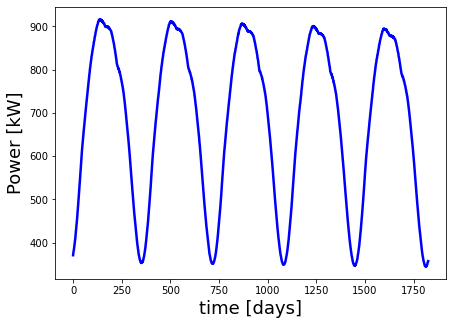

In [8]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(df_basic.Power.to_numpy(), color="blue", ls="-", lw=2.5)
ax.set_ylabel("Power [kW]", fontsize=18)
ax.set_xlabel("time [days]", fontsize=18)
#ax.set_xlim([85, 125])
#ax.set_ylim([800, 900])

## Further preprocess step

The input signal is the logarithmn of the daily power. In this way, the variability of the signal is reduced.

Text(0.5, 0, 'time [days]')

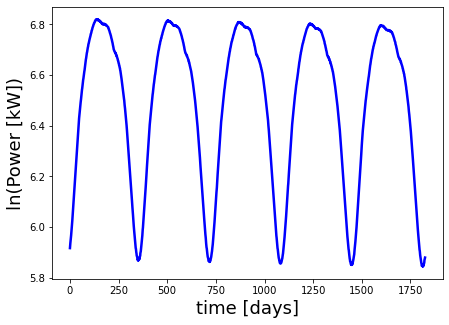

In [22]:
x_power = np.log(df_basic.Power.to_numpy())

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(x_power, ls="-", color="b", lw="2.5")
ax.set_ylabel("ln(Power [kW])", fontsize=18)
ax.set_xlabel("time [days]", fontsize=18)

## EEMD

**First step: decomposition of input power signal into set of IMFs, i.e.**

\begin{equation}
{\rm Input\, power\, signal} = \sum_i eIMF_i + {\rm residual}
\end{equation}

- Sometimes the last IMF is monotonically increasing with time - include a repeat if this happens? Should we worry about this?

In [10]:
# Initialize EEMD class
eemd   = EEMD(spline_kind="cubic", extrema_detection="parabol", trials=200, noise_width=0.01)
# trials = number of ensemble members M (# of copies of input signal)
# noise is added to each copied input signal -> noise_width =  standard deviation of Gaussian noise
eemd.noise_seed(1)
# run eemd / eIMFs contains the final set of IMFs
eIMFs  = eemd.eemd(x_power)
_, res = eemd.get_imfs_and_residue()
nIMFs  = eIMFs.shape[0]

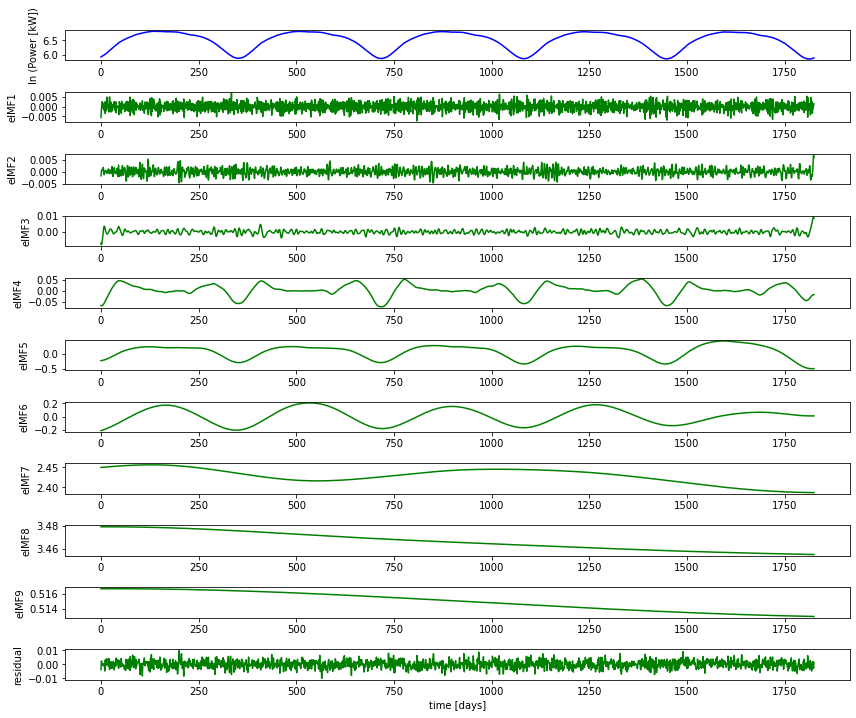

In [11]:
fig, ax = plt.subplots(nIMFs+2, 1, figsize=(12, 10))
ax[0].plot(x_power, "blue")
ax[0].set_ylabel("ln (Power [kW])")

for i in range(nIMFs):
    ax[i+1].plot(eIMFs[i], color="green")
    ax[i+1].set_ylabel("eIMF%i" %(i+1))
ax[nIMFs+1].plot(res, color="g")
ax[nIMFs+1].set_ylabel("residual")
ax[nIMFs+1].set_xlabel("time [days]")
plt.tight_layout()

**Second step: FT each IMF**

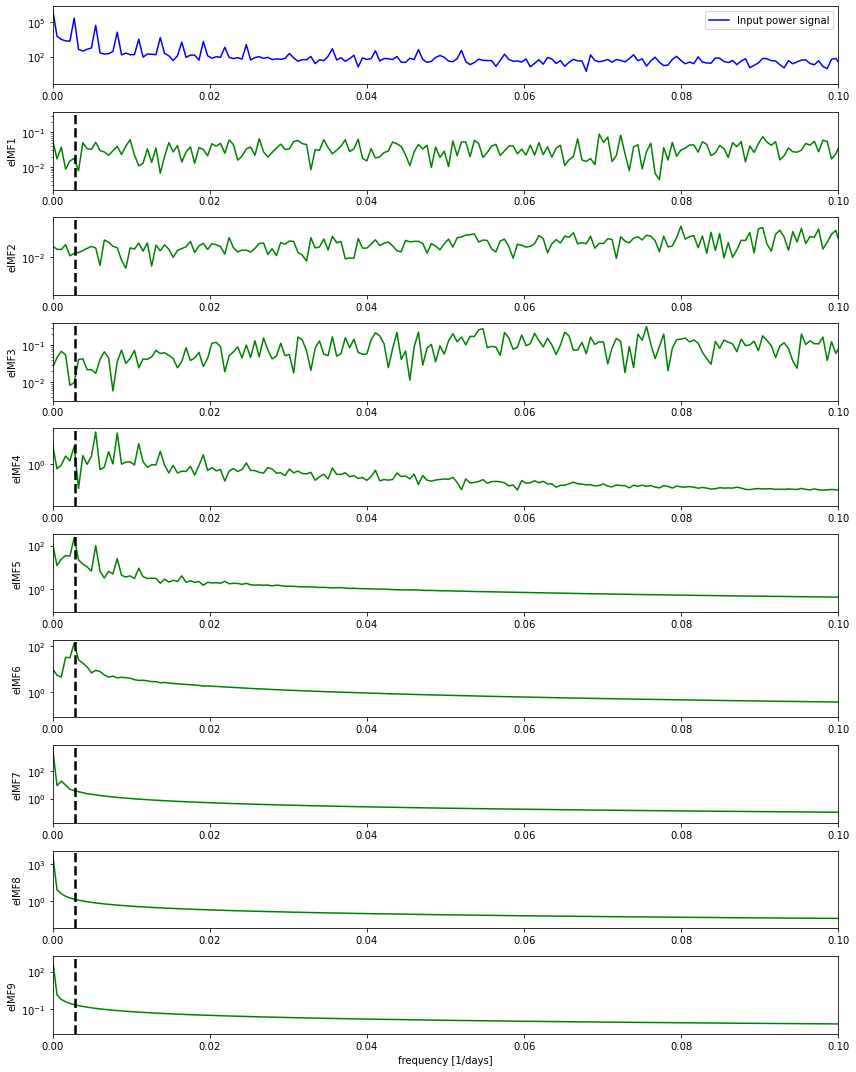

In [12]:
# Calculate FTs and plot them
plt.figure(figsize=(12, 15))

plt.subplot(nIMFs+1, 1, 1)
box_length  = df_basic["Power"].to_numpy().size
power_fft   = fftpack.fft(df_basic["Power"].to_numpy()) # FT input power signal
sample_freq = fftpack.fftfreq(box_length, d=1)
plt.plot(sample_freq[0:int(box_length/2)], np.abs(power_fft[0:int(box_length/2)]), color="blue", label="Input power signal")
plt.yscale("log")
plt.xlim([0.0, 0.1])
plt.legend()

power_IMFs = np.ones((nIMFs, box_length), dtype =complex)
for n in range(nIMFs):
    plt.subplot(nIMFs+1, 1, n+2)
    # Calculate FT of nth IMF
    power_IMFs[n] = fftpack.fft(eIMFs[n])
    plt.plot(sample_freq[0:int(box_length/2)], np.abs(power_IMFs[n][0:int(box_length/2)]), 'g')
    plt.ylabel("eIMF%i" %(n+1))
    plt.locator_params(axis='y', nbins=5)
    plt.yscale("log")
    plt.xlim([0.0, 0.1])
    plt.axvline(1./356, color="k", ls="--", lw=2.5) # frequency equivalent to 1 year period
plt.xlabel("frequency [1/days]")
plt.tight_layout()

In [13]:
# Calculate trend component 
# (i.e. the trend component contains all IMFs whose spectrum has less than 2 local maxima & 2 local minima)
emd   = EMD()
trend = np.zeros(x_power.shape)
for i in range(nIMFs):
    max_pos, _, min_pos, _, _ = emd.find_extrema(sample_freq, np.abs(power_IMFs[i]))
    print (i, max_pos.shape[0], min_pos.shape[0])
    if  max_pos.shape[0]<2 and min_pos.shape[0]<2:
        trend = trend + eIMFs[i]
        print ("Inside if conditon for nIMFs ", i)

# predicted degradation factor
eta_d_pred_0 = np.exp(trend)/np.exp(trend[0])

0 608 608
1 598 599
2 592 591
3 417 417
4 61 61
5 16 17
6 2 2
7 0 1
Inside if conditon for nIMFs  7
8 0 1
Inside if conditon for nIMFs  8


In [72]:
# Manually combine IMFs components into random and seasonal 
# (this part should be changed manually by inspecting last two plots)
random   = eIMFs[0] + eIMFs[1] + eIMFs[2] + eIMFs[3]
seasonal = eIMFs[4] + eIMFs[5] + eIMFs[6]  

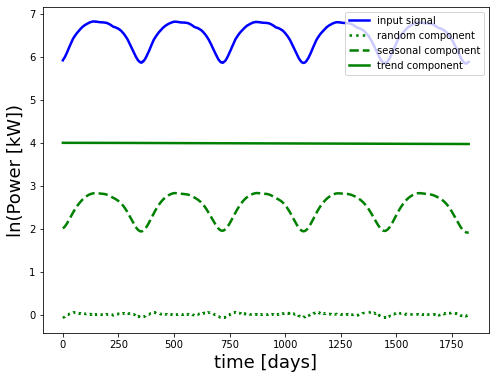

In [73]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x_power, color="blue", lw=2.5, label="input signal")
ax.plot(random, color="green", ls=":", lw=2.5, label="random component")
ax.plot(seasonal, color="green", ls="--", lw=2.5, label="seasonal component")
ax.plot(trend, color="green", ls="-", lw=2.5, label="trend component")
ax.set_ylabel("ln(Power [kW])", fontsize=18)
ax.set_xlabel("time [days]", fontsize=18)
ax.legend()

Text(0.5, 0, 'time [days]')

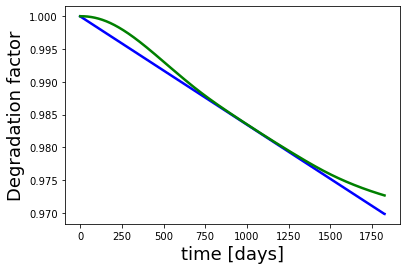

In [14]:
fig, ax = plt.subplots()
ax.plot(df_basic.Degradation.to_numpy(), color="blue", lw=2.5)
ax.plot(eta_d_pred_0, color="green", lw=2.5)
ax.set_ylabel("Degradation factor", fontsize=18)
ax.set_xlabel("time [days]", fontsize=18)

**Final step: Calculate degradation factor**

First, we use batch gradient descent to fit a line to the predicted degradation factor. 
Then, we can use the following equation to convert degradation factor $\eta_{d}$ into a degradation rate $r_d$:
\begin{equation}
\eta_d(t) = 1 +r_d\cdot t,
\end{equation}
where $t$ is the time given in years. This equation holds since the true degradation rate $r_d^{\rm true}$ is constant over the whole time series.

In [76]:
x          = np.arange(1, len(trend)+1, 1)
x_copy     = np.concatenate((np.ones(len(trend)), x))
x_copy     = np.transpose(x_copy.reshape(2, len(trend)))
y          = eta_d_pred_0
y          = np.array(y, ndmin=2)

theta      = np.array([[1], [0]])
theta      = gradientDescent(x_copy, y, theta, 1e-7, len(trend), numIterations=1000)
eta_d_pred = np.matmul(x_copy, theta)

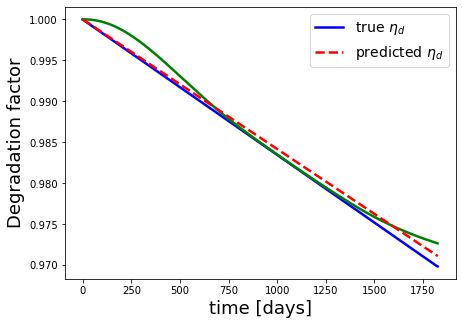

In [77]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(df_basic.Degradation.to_numpy(), color="blue", lw=2.5, label=r"true $\eta_d$")
ax.plot(eta_d_pred_0, color="green", lw=2.5)
ax.plot(x, eta_d_pred, color="red", ls="--", lw=2.5, label=r"predicted $\eta_d$")

ax.set_ylabel("Degradation factor", fontsize=18)
ax.set_xlabel("time [days]", fontsize=18)
ax.legend(fontsize=14)

In [100]:
# degradation factor -> degradation rate
time       = np.arange(1, len(eta_d_pred) + 1, 1) # [days]
time       = time/365. # [years]
r_d_pred   = np.divide(eta_d_pred[:, 0] - 1, time)
r_d_true   = np.divide(df_basic.Degradation.to_numpy() - 1, time)
print (np.min(r_d_pred), np.max(r_d_pred))
r_d_pred_0 = np.mean(r_d_pred)

-0.005773846187133997 -0.005768159886678781


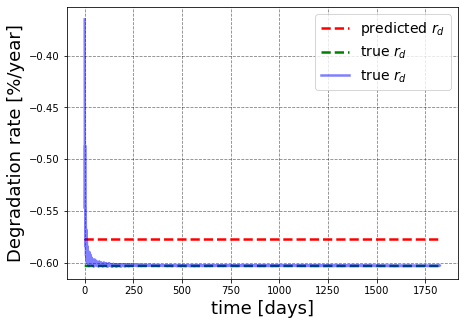

In [96]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(r_d_pred*100, color="red", ls="--", lw=2.5, label="predicted $r_d$")
ax.plot(np.ones(len(r_d_pred))*r_d_true_0*100, color="green", ls="--", lw=2.5, label="true $r_d$")
ax.plot(r_d_true*100, color="blue", ls="-", lw=2.5, alpha=0.5, label="true $r_d$")
ax.set_xlabel("time [days]", fontsize=18)
ax.set_ylabel("Degradation rate [%/year]", fontsize=18)
#ax.set_ylim([-1, -0.9])
ax.legend(fontsize=14)
ax.grid(ls="--", color="k", alpha=0.5)

- Why I obtain the weird behaviour for the true degradation factor at the start of the time series?

In [114]:
RMSE = np.sqrt(np.power(r_d_true_0*100 - r_d_pred_0*100, 2)/1)
print ("RMSE = %.3f percentage/year" %(RMSE))

RMSE = 0.026 percentage/year


## Second part: generalization to all basic datasets

In [24]:
synth_name  = "basic"
path_to_zip = "../data/raw/synthetic_" + synth_name + ".zip"

df          = {}
eIMFs       = {}
res         = {}
nIMFs       = np.zeros(50)
power       = {}
rd_pred     = np.zeros(50)
rd_true     = np.zeros(50)
eta_d       = {} 
eta_d_noisy = {}
trend       = {}

for index in range(0, 50):
    print ("running for %i time series" %index)
    _df, _eemd, _results = eemd_analysis_check_extrema(path_to_zip, index=index, sampling_function=np.mean, 
                                                       seed=True, verbose=False)
    df[index]          = _df
    eIMFs[index]       = _eemd[0]
    res[index]         = _eemd[1]
    nIMFs[index]       = _eemd[2]
    power[index]       = _eemd[3]
    rd_true[index]     = _results[0]
    rd_pred[index]     = _results[1]
    eta_d_noisy[index] =_results[2]
    eta_d[index]       = _results[3]
    trend[index]       = _results[4]

running for 0 time series
running for 1 time series
running for 2 time series
running for 3 time series
running for 4 time series
running for 5 time series
running for 6 time series
running for 7 time series
running for 8 time series
running for 9 time series
running for 10 time series
running for 11 time series
running for 12 time series
running for 13 time series
running for 14 time series
running for 15 time series
running for 16 time series
running for 17 time series
running for 18 time series
running for 19 time series
running for 20 time series
running for 21 time series
running for 22 time series
running for 23 time series
running for 24 time series
running for 25 time series
running for 26 time series
running for 27 time series
running for 28 time series
running for 29 time series
running for 30 time series
running for 31 time series
running for 32 time series
running for 33 time series
running for 34 time series
running for 35 time series
running for 36 time series
running for

RMSE of the degradation rate is 0.362 percentage/year


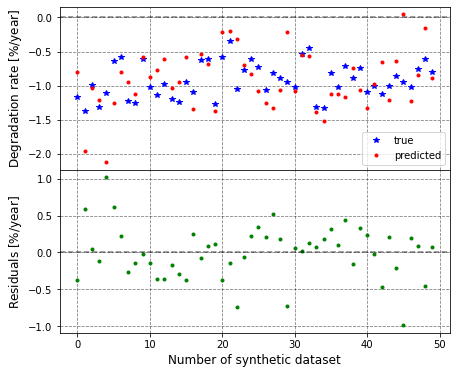

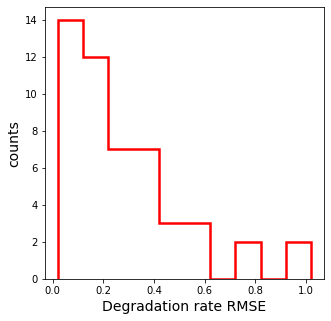

In [25]:
plot_eemd_rd(rd_true, rd_pred)

rmse = mean_squared_error(rd_true*100, rd_pred*100, squared=False)
print ("RMSE of the degradation rate is %.3f percentage/year" %(rmse))

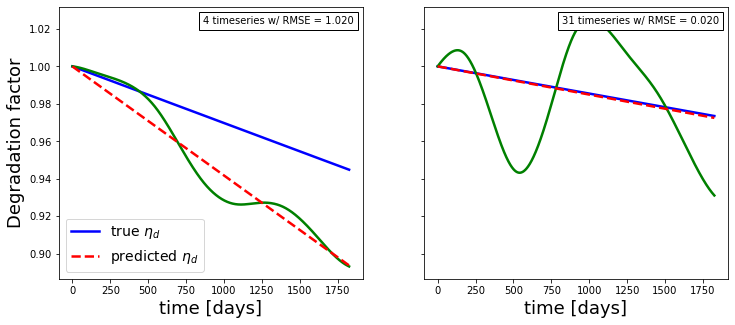

In [26]:
plot_eemd_rd_extrema(df, rd_true, rd_pred, eta_d, eta_d_noisy)